# Предсказание аварий: описание проекта

**Цель проекта** - создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Предложение решения задачи от заказчика

* Создать модель предсказания ДТП (целеввое значение - `at_fault` в таблице `parties`)
* * Для модели выбрать тип виновника - только машина (**car**)
* * Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа **scratch**
* * Для моделирования ограничиться данными за 2012 год - они самые свежие
* * Обязательное условие - учесть фактор возраста автомобиля
* На основе модели исследовать основные факторы ДТП.
* Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
* * Возможно ли создать адекватную систему оценки водительского риска при выдаче авто?
* * Какие ещё факторы нужно учесть?
* * Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Общий план проекта

ТБД

# Импорт библиотек

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from sqlalchemy import create_engine, inspect
from ydata_profiling import ProfileReport

In [2]:
import yaml
from os import path, makedirs

In [3]:
pd.set_option('display.max_columns', None)

# Подключение к базе данных

In [4]:
# чтобы выложить проект на гитхабе и не палить параметры подключения,
# загрузим их из yml файла (файл добавлен в .gitignore)
with open('db_config.yml', 'r') as file:
    db_config = yaml.safe_load(file)

# строка для подключения к базе
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

In [6]:
# осмотр таблиц и клонок
inspector = inspect(engine)
table_names = inspector.get_table_names()

for table_name in table_names:
    columns = inspector.get_columns(table_name)
    print(f"Table: {table_name}")
    display(pd.DataFrame(columns))

Table: collisions


,name,type,nullable,default,autoincrement,comment
0,case_id,TEXT,True,None,False,None
1,county_city_location,TEXT,True,None,False,None
2,county_location,TEXT,True,None,False,None
3,distance,REAL,True,None,False,None
4,direction,TEXT,True,None,False,None
5,intersection,INTEGER,True,None,False,None
6,weather_1,TEXT,True,None,False,None
7,location_type,TEXT,True,None,False,None
8,collision_damage,TEXT,True,None,False,None
9,party_count,INTEGER,True,None,False,None


Table: case_ids


,name,type,nullable,default,autoincrement,comment
0,case_id,TEXT,True,None,False,None
1,db_year,TEXT,True,None,False,None


Table: parties


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,True,None,False,None
1,case_id,TEXT,True,None,False,None
2,party_number,INTEGER,True,None,False,None
3,party_type,TEXT,True,None,False,None
4,at_fault,INTEGER,True,None,False,None
5,insurance_premium,INTEGER,True,None,False,None
6,party_sobriety,TEXT,True,None,False,None
7,party_drug_physical,TEXT,True,None,False,None
8,cellphone_in_use,INTEGER,True,None,False,None


Table: vehicles


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,True,None,False,None
1,case_id,TEXT,True,None,False,None
2,party_number,INTEGER,True,None,False,None
3,vehicle_type,TEXT,True,None,False,None
4,vehicle_transmission,TEXT,True,None,False,None
5,vehicle_age,INTEGER,True,None,False,None


## Загрузка датасетов и отчётов

In [7]:
# процедура для загрузки датасетов
def download_tables(engine, table_names, datasets_folder='./datasets'):
    print("Start downloading tables:", table_names)
    if not path.exists(datasets_folder):
                makedirs(datasets_folder)

    for table_name in table_names:
        dataset_path = datasets_folder + '/' + engine.url.database + '_' + table_name + '.csv'
        
        if not path.exists(dataset_path):
            print("Downloading table:", dataset_path)
            query = '''SELECT * FROM {}'''.format(table_name)
            df = pd.read_sql_query(query, con=engine)
            df.to_csv(dataset_path)
            print("Download complete:", table_name)
            del df
        else:
            print(f"Table {table_name} is already downloaded:", dataset_path)
    
    print("Download comlete!")


In [8]:
download_tables(engine, table_names)

Start downloading tables: ['collisions', 'case_ids', 'parties', 'vehicles']
Table collisions is already downloaded: ./datasets/data-science-vehicle-db_collisions.csv
Table case_ids is already downloaded: ./datasets/data-science-vehicle-db_case_ids.csv
Table parties is already downloaded: ./datasets/data-science-vehicle-db_parties.csv
Table vehicles is already downloaded: ./datasets/data-science-vehicle-db_vehicles.csv
Download comlete!


In [9]:
# процедура создания отчётов через ydata-profiling
def make_reports(engine, table_names, datasets_folder='./datasets', reports_folder='./reports'):
    print("Start reporting for tables:", table_names)
    if not path.exists(reports_folder):
            makedirs(reports_folder)
    
    for table_name in table_names:
        report_path = reports_folder + '/' + engine.url.database + '_' + table_name + '.html'
        dataset_path = datasets_folder + '/' + engine.url.database + '_' + table_name + '.csv'
                
        if not path.exists(report_path):
            print('Forming report:', report_path)
            if not path.exists(dataset_path):
                query = '''SELECT * FROM {}'''.format(table_name)
                df = pd.read_sql_query(query, con=engine)
            else:
                 df = pd.read_csv(dataset_path, index_col=0)
            report = ProfileReport(df)
            report.to_file(report_path)
            del df
        else:
            print(f"Report for {table_name} already exists: {report_path}")
        
    print('Reporting completed!')
             

In [10]:
make_reports(engine, table_names)

Start reporting for tables: ['collisions', 'case_ids', 'parties', 'vehicles']
Report for collisions already exists: ./reports/data-science-vehicle-db_collisions.html
Report for case_ids already exists: ./reports/data-science-vehicle-db_case_ids.html
Report for parties already exists: ./reports/data-science-vehicle-db_parties.html
Report for vehicles already exists: ./reports/data-science-vehicle-db_vehicles.html
Reporting completed!


## Первичный анализ таблиц базы данных

Краткое описание таблиц базы данных:

* `collisions` — общая информация о ДТП
Имеет уникальный `case_id`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

* `parties` — информация об участниках ДТП
Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. Если нужен уникальный идентификатор, это `case_id` and `party_number`.

* `vehicles` — информация о пострадавших машинах
Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `case_id` and `party_number`.

* В базе также присутствует таблица `case_ids`, которая содержит только два поля: `case_id` и `db_year`. При этом все значения в поле `db_year` одинаковые (2021), эта таблица не несёт никакой информации и, скорее всего, оказалась в схеме случайно

* Три основные таблицы связаны между собой полем `case_id`, позволяющим связать стороны и автомобили с каждым зафиксированным случаем

In [11]:
# будем рассматривать только эти таблицы
table_names = ['collisions', 'parties', 'vehicles']

Осмотрим данные каждой таблице, загрузив по 5 записей из каждой

In [12]:
for table_name in table_names:
    query = "SELECT * FROM {} LIMIT 5".format(table_name)
    print("Table:", table_name)
    df = pd.read_sql_query(query, engine)
    display(df)
    del df

Table: collisions


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Table: parties


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Table: vehicles


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [13]:
# посмотрим уникальные типы повреждений
query = "SELECT DISTINCT collision_damage FROM collisions"
display(pd.read_sql_query(query, engine))

,collision_damage
0,scratch
1,severe damage
2,small damage
3,middle damage
4,fatal


Выясним, в какие месяцы происходит наибольшее количечество аварий за весь период наблюдений. Рассмотрим случаи со всеми типами повреждений

In [14]:
# какой временной период охватывают данные
query = "SELECT min(collision_date), max(collision_date) FROM collisions"
display(pd.read_sql_query(query, engine))

,min,max
0,2009-01-01,2020-07-26


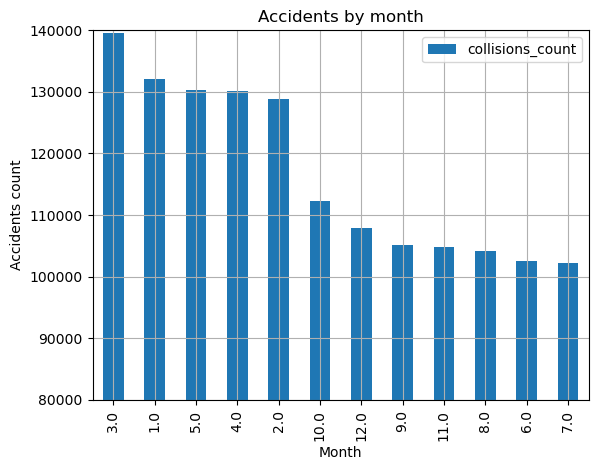

In [15]:
query = '''
SELECT EXTRACT(MONTH FROM collision_date) AS collisions_month, count(*) as collisions_count
FROM collisions AS c 
GROUP BY collisions_month
ORDER BY collisions_count DESC
'''
df = pd.read_sql_query(query, engine, index_col='collisions_month').astype(int)
df.plot(kind='bar',
        grid=True,
        xlabel='Month',
        ylabel='Accidents count',
        title='Accidents by month',
        ylim=(80000, 140000))
plt.show()

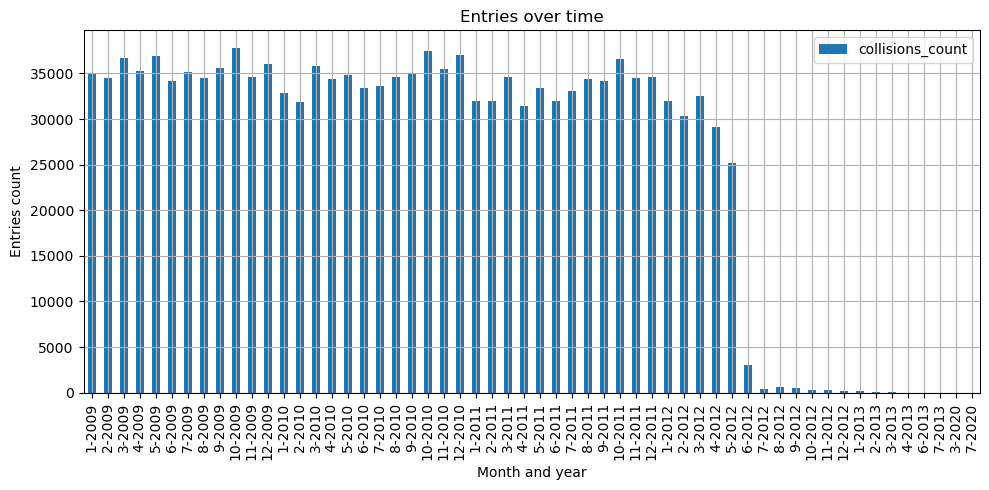

In [16]:
# проанализируем плотность данных по месяцам
query = '''
SELECT EXTRACT(YEAR FROM collision_date) AS collisions_year,
EXTRACT(MONTH FROM collision_date) AS collisions_month, 
count(*) as collisions_count
FROM collisions AS c 
GROUP BY collisions_year, collisions_month
ORDER BY collisions_year, collisions_month
'''
df = pd.read_sql_query(query, engine).astype(int)
# display(df)

df.plot(kind='bar',
        y='collisions_count',
        figsize=(10, 5),
        grid=True,
        xlabel='Month and year',
        ylabel='Entries count',
        title='Entries over time')
plt.xticks(ticks=df.index,
           labels=[f"{month}-{year}" for year, month in zip(df['collisions_year'], df['collisions_month'])])
plt.tight_layout()
plt.show()

## Предварительный вывод

* Поле `case_id` в базе данных имеет тип TEXT, хотя данные в нём являются целыми числами
* Если сравнивать количество аварий по месяцам, можно разделить месяцы на три группы:
* * Месяц с наибольшим количеством зафиксированных случаев: март
* * На втором месте идут месяцы с повышенным количеством аварий, примерно равные между собой: январь, февраль, апрель, май
* * Остальные месяцы с пониженным количеством аварий
* Если объединить март со второй группой, то получится, что в первой половине года (с января по май), каждый месяц наблюдается больше аварий по сравнению со второй половиной года
* Количество записей заметно падает, начиная с мая 2012 года. Не думаю, что это связано с тем, что количество аварий драматично сократилось. Заказчик предлагает использовать для обучения модели данные за 2012 год, но, возможно, лучше взять данные за 2011-2012 года

## Углублённый анализ таблиц

ТБД

# Подготовка данных для моделирования

## Выбор полей для таблицы

Подготовим SQL запрос и загрузим данные на основе предложений от заказчика, привдённых в начальном разделе, но с изменённым временным интервалом, поскольку данные за 2012 год представлены в неравномерном количестве. Датасет может быть очень большой, поэтому загрузим только 1000 записей, чтобы оценить, какие поля выбрать.

Также выберем только те случаи, для которых известен возраст автомобилей, поскольку учёт этого признака явно прописан в условии задачи.

In [17]:
query = '''
WITH
-- filter on damage type and date
collisions_filtered AS (
SELECT *
FROM collisions
WHERE collision_damage != 'scratch'
AND collision_date BETWEEN '2011-04-01' AND '2012-04-01'
),
-- filter on party type
parties_filtered AS (
SELECT *
FROM parties
WHERE party_type = 'car'
),
-- filter on vehicle age
vehicles_filtered AS (
SELECT *
FROM vehicles
WHERE vehicle_age IS NOT NULL
)
-- main query
SELECT *
FROM parties_filtered AS p
-- compare with collision info
INNER JOIN collisions_filtered AS c
ON p.case_id = c.case_id
-- add vehicle info
INNER JOIN vehicles_filtered AS v 
ON p.case_id = v.case_id AND p.party_number = v.party_number
LIMIT 1000
;
'''

df_preview = pd.read_sql_query(query, engine)
df_preview.info()
df_preview.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1000 non-null   int64  
 1   case_id                      1000 non-null   object 
 2   party_number                 1000 non-null   int64  
 3   party_type                   1000 non-null   object 
 4   at_fault                     1000 non-null   int64  
 5   insurance_premium            987 non-null    float64
 6   party_sobriety               984 non-null    object 
 7   party_drug_physical          44 non-null     object 
 8   cellphone_in_use             920 non-null    float64
 9   case_id                      1000 non-null   object 
 10  county_city_location         1000 non-null   object 
 11  county_location              1000 non-null   object 
 12  distance                     1000 non-null   float64
 13  direction          

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1140926,4753493,1,car,1,33.0,had not been drinking,None,0.0,4753493,3300,riverside,100.0,south,0.0,clear,highway,small damage,2,vehicle code violation,other hazardous violation,hit object,fixed object,dry,normal,daylight,none,2011-05-24,15:30:00,622287,4753493,1,sedan,manual,5
1,1868604,5161541,1,car,1,70.0,had not been drinking,None,0.0,5161541,3700,san diego,387.0,west,0.0,clear,None,severe damage,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,daylight,none,2011-04-14,10:16:00,1022590,5161541,1,coupe,auto,11
2,1899538,5178033,1,car,1,56.0,had not been drinking,None,0.0,5178033,4905,sonoma,0.0,east,0.0,clear,None,middle damage,1,vehicle code violation,speeding,overturned,None,dry,normal,daylight,none,2011-05-11,07:27:00,1039420,5178033,1,coupe,manual,9
3,1932534,5196893,1,car,1,48.0,had not been drinking,None,0.0,5196893,4802,solano,2640.0,west,0.0,clear,highway,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2011-05-03,09:20:00,1058273,5196893,1,sedan,manual,10
4,1932919,5197094,2,car,0,27.0,had not been drinking,None,0.0,5197094,3700,san diego,1584.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,following too closely,rear end,other motor vehicle,dry,normal,daylight,none,2011-05-09,16:30:00,1058466,5197094,2,sedan,manual,6


Некоторые факторы вроде трезвости водителя могут иметь значительное влияние на вероятность аварии, но мы не можем их учитывать в модели, поскольку они неизвестны до наступления аварии. Поэтому для формирования датасета выберем только те поля, информация в которых известна заранее.

Все идентификаторы сторон и кейсов также не войдут в обучающий датасет, поскольку не влияют на вероятность аварии

Мы выберем поля, характеризующие место происшествия, дорогу, погоду и некоторые характеристики автомобиля.

Мы возьмём поле `county_location` для того, чтобы использовать его в анализе, но не будем использовать его в качестве признака для обучения, поскольку у нас есть поле `county_city_location` с информацией о конкретных индексах районов.

Мы не будем брать поле `road_surface`, описывающее состояние поверхности дороги, поскольку мы не владеем этой информацией заранее

In [18]:
# поля для формирования итоговой таблицы
# буду указывать сразу с аллиасами таблиц
fields = [
    'p.at_fault', # целевой признак, указывающий виновника аварии
    'c.county_city_location', # индекс района
    'c.county_location', # название округа, не будет использовано в обучении
    'c.distance', 'c.direction', 'c.intersection', # характеристики места аварии
    'c.weather_1', # погода
    'c.location_type', # тип дороги
    'c.road_condition_1', # состояние дороги, может быть известно заранее, а может и нет
    'c.lighting', # освещённость дороги
    'v.vehicle_age' # возраст автомобиля
]

## Загрузка датасета

In [19]:
query = '''
WITH
-- filter on damage type and date
collisions_filtered AS (
SELECT *
FROM collisions
WHERE collision_damage != 'scratch'
AND collision_date BETWEEN '2011-04-01' AND '2012-04-01'
),
-- filter on party type
parties_filtered AS (
SELECT *
FROM parties
WHERE party_type = 'car'
),
-- filter on vehicle age
vehicles_filtered AS (
SELECT *
FROM vehicles
WHERE vehicle_age IS NOT NULL
)
-- main query
SELECT {}
FROM parties_filtered AS p
-- compare with collision info
INNER JOIN collisions_filtered AS c
ON p.case_id = c.case_id
-- add vehicle info
INNER JOIN vehicles_filtered AS v 
ON p.case_id = v.case_id AND p.party_number = v.party_number
;
'''.format(','.join(fields))

df = pd.read_sql_query(query, engine)
df.info()
display(df.head())
print('Duplicated rows:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140441 entries, 0 to 140440
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              140441 non-null  int64  
 1   county_city_location  140441 non-null  object 
 2   county_location       140441 non-null  object 
 3   distance              140441 non-null  float64
 4   direction             107611 non-null  object 
 5   intersection          140002 non-null  float64
 6   weather_1             139958 non-null  object 
 7   location_type         65623 non-null   object 
 8   road_condition_1      139764 non-null  object 
 9   lighting              139963 non-null  object 
 10  vehicle_age           140441 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 11.8+ MB


,at_fault,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_condition_1,lighting,vehicle_age
0,1,3300,riverside,100.0,south,0.0,clear,highway,normal,daylight,5
1,1,3400,sacramento,1056.0,south,0.0,raining,highway,normal,daylight,2
2,1,1000,fresno,0.0,None,1.0,clear,None,normal,daylight,2
3,1,1300,imperial,1056.0,west,0.0,clear,highway,normal,daylight,9
4,0,3026,orange,528.0,south,0.0,clear,highway,construction,daylight,4


Duplicated rows: 22376


In [20]:
# удалим продублированные записи
df = df.drop_duplicates(keep='first')
print('Duplicated rows:', df.duplicated().sum())
print(df.shape)

Duplicated rows: 0
(118065, 11)


In [21]:
# построим репорт и сохраним его
path_to_report = './reports/train_data_report.html'

if not path.exists(path_to_report):
    report = ProfileReport(df)
    report.to_file(path_to_report)
else:
    print('Report already exists')

Report already exists


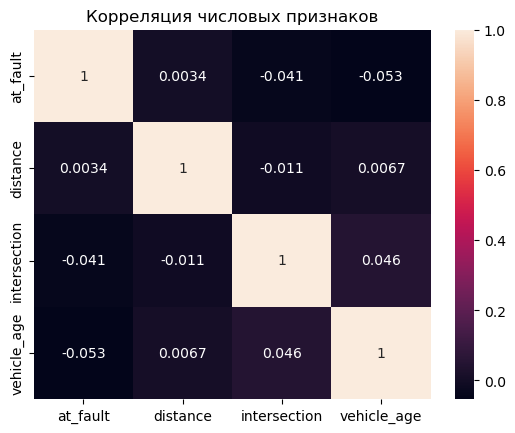

In [24]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Корреляция числовых признаков")
plt.show()

In [28]:
# столбцы с пропусками
df.isna().sum()

at_fault                    0
county_city_location        0
county_location             0
distance                    0
direction               16856
intersection              424
weather_1                 474
location_type           57629
road_condition_1          654
lighting                  470
vehicle_age                 0
dtype: int64

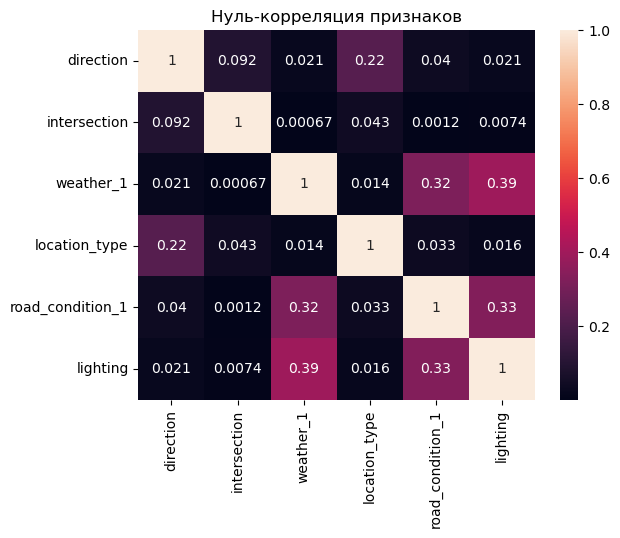

In [30]:
# nullity matrix
sns.heatmap(df.drop(columns=['at_fault', 'county_city_location',
                             'county_location', 'distance',
                             'vehicle_age']).isna().corr(), annot=True)
plt.title("Нуль-корреляция признаков")
plt.show()

Признаки `weather_1` и `road_condition_1` имеют дисбаланс классов

In [41]:
for c in ('weather_1', 'road_condition_1'):
    print(df[c].value_counts())
    print('\n')

weather_1
clear      96567
cloudy     16724
raining     3454
fog          518
snowing      207
other         82
wind          39
Name: count, dtype: int64


road_condition_1
normal            112799
construction        2595
obstruction          595
other                477
holes                443
loose material       329
reduced width        116
flooded               57
Name: count, dtype: int64




В столбцах `direction` и `location_type` присутствует заметная доля пропусков:

In [46]:
for c in ('direction', 'location_type'):
    print(c)
    print('{:.2f}'.format(df[c].isna().sum() / df.shape[0]))
    print('\n')

direction
0.14


location_type
0.49




Также распределение значений в столбце `distance` очень сильно смещено, что может говорить о наличии выбросов

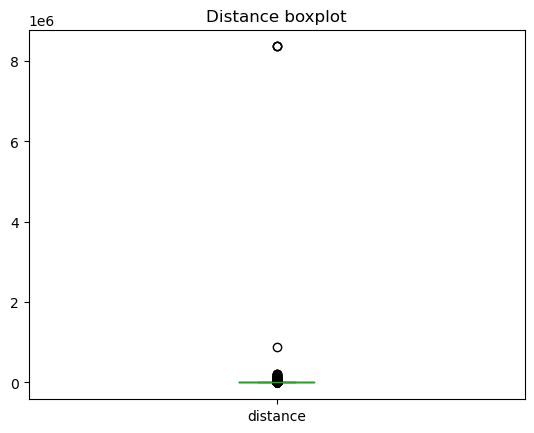

In [58]:
df['distance'].plot(kind='box')
plt.title('Distance boxplot')
plt.show()

Боксплот оказался не очень информативным, поэтому посчитаем значения на границах боксплота

In [85]:
# функция для рассчёта границ боксплота
def boxplot_fences(series: pd.Series) -> pd.Series:
    iqr = ss.iqr(series)
    q = series.quantile([0.25, 0.5, 0.75])
    return pd.Series(
        {
            'q1': q.loc[0.25],
            'q2': q.loc[0.5],
            'q3': q.loc[0.75],
            'lower_fence': q.loc[0.25] - 1.5 * iqr,
            'higher_fence': q.loc[0.75] + 1.5 * iqr
        }
    )

In [88]:
boxplot_fences(df['distance'])

q1                30.0
q2               200.0
q3               700.0
lower_fence     -975.0
higher_fence    1705.0
dtype: float64